In [5]:
import pandas as pd

In [7]:
data = pd.read_csv('/Users/niloy74/UoB/Data Analytics and Predictive Modelling/report.csv')
data

,FullName,ClubName,AgeGroup,Position,FIFARating,MinutesPlayed,GAContribution,FantasyScore,MarketValue,TransferStatus
0,Erling Haaland,Manchester City,21 and under,Forward,88,2767,45,7.8,180000000,Retained
1,Bukayo Saka,Arsenal,21 and under,Midfielder,82,3183,26,5.3,120000000,Retained
2,Declan Rice,West Ham United,22-25,Midfielder,84,3272,7,3.1,110000000,Transferred
3,Mohamed Salah,Liverpool,30 and above,Forward,90,3290,32,6.3,110000000,Retained
4,Phil Foden,Manchester City,22-25,Midfielder,85,1832,18,4.4,110000000,Retained
...,...,...,...,...,...,...,...,...,...,...
571,Alex Gilbert,Brentford,21 and under,Forward,59,0,0,0.0,100000,Retained
572,Lewis Brunt,Leicester City,21 and under,Midfielder,55,22,0,1.0,100000,Retained
573,Tristan Crama,Brentford,21 and under,Defender,58,0,0,0.0,100000,Retained
574,Tawanda Maswanhise,Leicester City,21 and under,Midfielder,60,0,0,0.0,50000,Retained


Cluster Summary:
   Cluster Number  Total Members IQR FIFARating (25%-75%)  \
0               0             32            (58.0, 61.25)   
1               1             28            (57.75, 62.5)   

  IQR MinutesPlayed (25%-75%) IQR GAContribution (25%-75%)  \
0                  (0.0, 0.0)                   (0.0, 0.0)   
1                  (0.0, 0.0)                   (0.0, 0.0)   

  IQR FantasyScore (25%-75%) IQR MarketValue (25%-75%)  \
0                 (0.0, 0.0)      (200000.0, 650000.0)   
1                 (0.0, 0.0)     (250000.0, 1625000.0)   

   Average Silhouette Score  Average Distance from Core  
0                  0.828988                    0.347303  
1                  0.772945                    0.479947  

Validity Metrics:
                 Metric     Value
0      Silhouette Index  0.802835
1  Davies-Bouldin Index  0.305740
2          Average WCSS  7.468729

Medoid Distance Matrix:
           Cluster 0  Cluster 1
Cluster 0   0.000000   2.405321
Cluster 1   2.40532

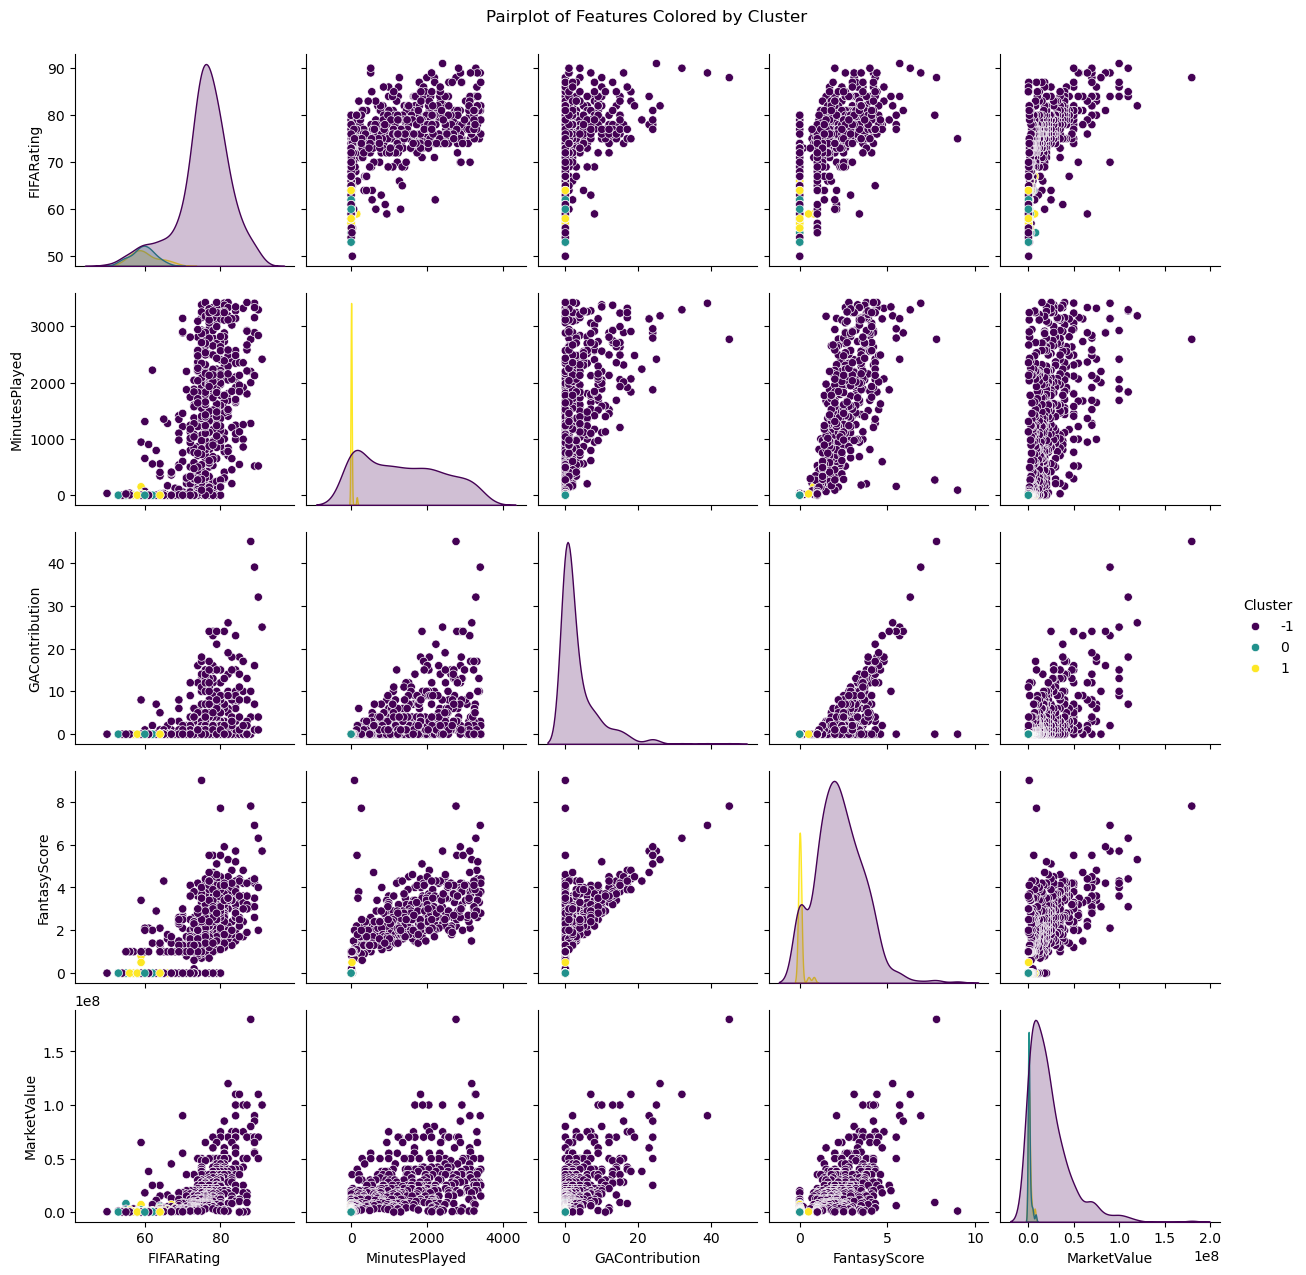

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Columns for clustering
columns = [
    "AgeGroup",
    "Position",
    "FIFARating",
    "MinutesPlayed",
    "GAContribution",
    "FantasyScore",
    "MarketValue",
]

# Encoding qualitative variables
label_encoders = {}
for col in ["AgeGroup", "Position"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing quantitative features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Perform OPTICS clustering
optics = OPTICS(metric="cosine", min_samples=10, xi=0.25)
labels = optics.fit_predict(data_scaled)

# Add cluster labels to the dataframe
data["Cluster"] = labels

# Filter out noise points for silhouette and other metrics (-1 is noise in OPTICS)
valid_labels = labels[labels != -1]
valid_data_scaled = data_scaled[labels != -1]

# Calculate validity metrics for valid clusters
if len(set(valid_labels)) > 1:  # Metrics require at least 2 clusters
    silhouette_avg = silhouette_score(valid_data_scaled, valid_labels, metric="manhattan")
    davies_bouldin = davies_bouldin_score(valid_data_scaled, valid_labels)
else:
    silhouette_avg = np.nan
    davies_bouldin = np.nan

# Calculate per-cluster silhouette scores
silhouette_vals = silhouette_samples(valid_data_scaled, valid_labels, metric="manhattan")

# Create a summary table for clusters
cluster_info = []
numeric_columns = ["FIFARating", "MinutesPlayed", "GAContribution", "FantasyScore", "MarketValue"]

unique_clusters = set(valid_labels)
for cluster_num in unique_clusters:
    cluster_data = data[data["Cluster"] == cluster_num]
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]

    # Metrics for the cluster
    total_members = len(cluster_data)
    variable_iqr = {
        f"IQR {col} (25%-75%)": (np.percentile(cluster_data[col], 25), np.percentile(cluster_data[col], 75))
        for col in numeric_columns
    }
    avg_silhouette = silhouette_vals[valid_labels == cluster_num].mean() if len(cluster_data) > 1 else np.nan
    avg_distance = np.mean(
        cdist(cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cityblock")
    )

    cluster_info.append(
        {
            "Cluster Number": cluster_num,
            "Total Members": total_members,
            **variable_iqr,
            "Average Silhouette Score": avg_silhouette,
            "Average Distance from Core": avg_distance,
        }
    )

# Convert cluster summary to DataFrame
cluster_summary_df = pd.DataFrame(cluster_info)

# Compute the Average Within-Cluster Sum of Squares (WCSS)
wcss_list = []
for cluster_num in unique_clusters:
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]
    dist_to_core = cdist(
        cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cityblock"
    )
    wcss = np.sum(dist_to_core**2)  # Square of the distances
    wcss_list.append(wcss)

average_wcss = np.mean(wcss_list) if wcss_list else np.nan

# Create a summary table for validity metrics
validity_metrics = {
    "Metric": ["Silhouette Index", "Davies-Bouldin Index", "Average WCSS"],
    "Value": [silhouette_avg, davies_bouldin, average_wcss],
}
validity_metrics_df = pd.DataFrame(validity_metrics)

# Compute pairwise distance matrix between each cluster's core points
cluster_cores = np.array([
    np.mean(valid_data_scaled[valid_labels == cluster_num], axis=0)
    for cluster_num in unique_clusters
])

medoid_dist_matrix = cdist(cluster_cores, cluster_cores, metric="cityblock")
medoid_dist_matrix_df = pd.DataFrame(medoid_dist_matrix, columns=[f"Cluster {i}" for i in unique_clusters],
                                      index=[f"Cluster {i}" for i in unique_clusters])

# Output results to CSV files
cluster_summary_df.to_csv("OPcluster_summary_OPTICS.csv", index=False)
validity_metrics_df.to_csv("OPcluster_validity_metrics_OPTICS.csv", index=False)
medoid_dist_matrix_df.to_csv("OPmedoid_distance_matrix_OPTICS.csv")

# Print the validity metrics
print("Cluster Summary:")
print(cluster_summary_df)
print("\nValidity Metrics:")
print(validity_metrics_df)
print("\nMedoid Distance Matrix:")
print(medoid_dist_matrix_df)

# Pairplot to show pairwise relationships between features
sns.pairplot(data, hue="Cluster", vars=numeric_columns, palette="viridis")
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)

# Save the pairplot as a PNG file
plt.savefig("OPpairplot_clusters_OPTICS.png")
plt.show()


Cluster Summary:
   Cluster Number  Total Members IQR FIFARating (25%-75%)  \
0               0            119             (77.0, 83.5)   
1               1            100             (76.0, 80.0)   
2               2            174             (59.0, 72.0)   

  IQR MinutesPlayed (25%-75%) IQR GAContribution (25%-75%)  \
0            (1920.5, 2884.0)                  (6.0, 14.5)   
1          (1606.25, 2664.75)                   (0.0, 3.0)   
2                (0.0, 166.5)                   (0.0, 0.0)   

  IQR FantasyScore (25%-75%) IQR MarketValue (25%-75%)  \
0                (2.9, 4.15)  (28000000.0, 62500000.0)   
1                 (2.1, 3.2)  (12000000.0, 30000000.0)   
2                 (0.0, 1.1)     (350000.0, 8750000.0)   

   Average Silhouette Score  Average Distance from Core  
0                  0.523429                    0.224914  
1                  0.508878                    0.233052  
2                  0.687780                    0.204290  

Validity Metrics:
     

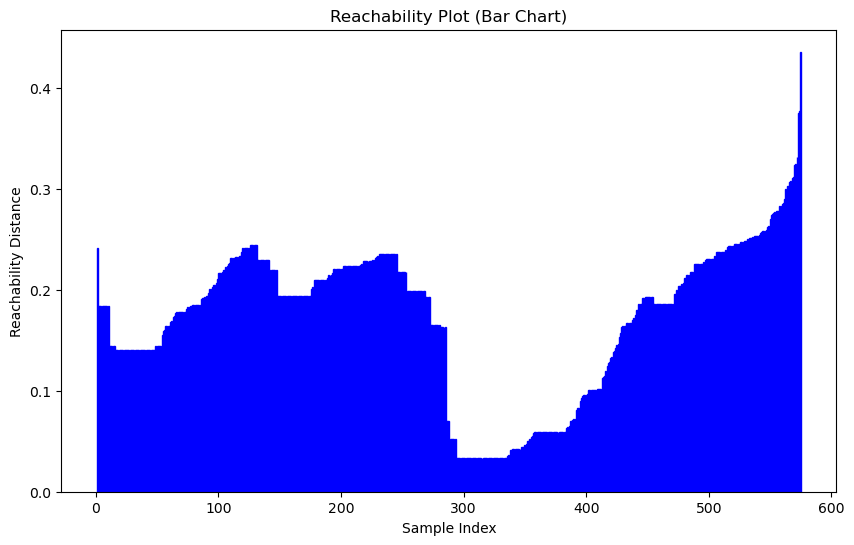

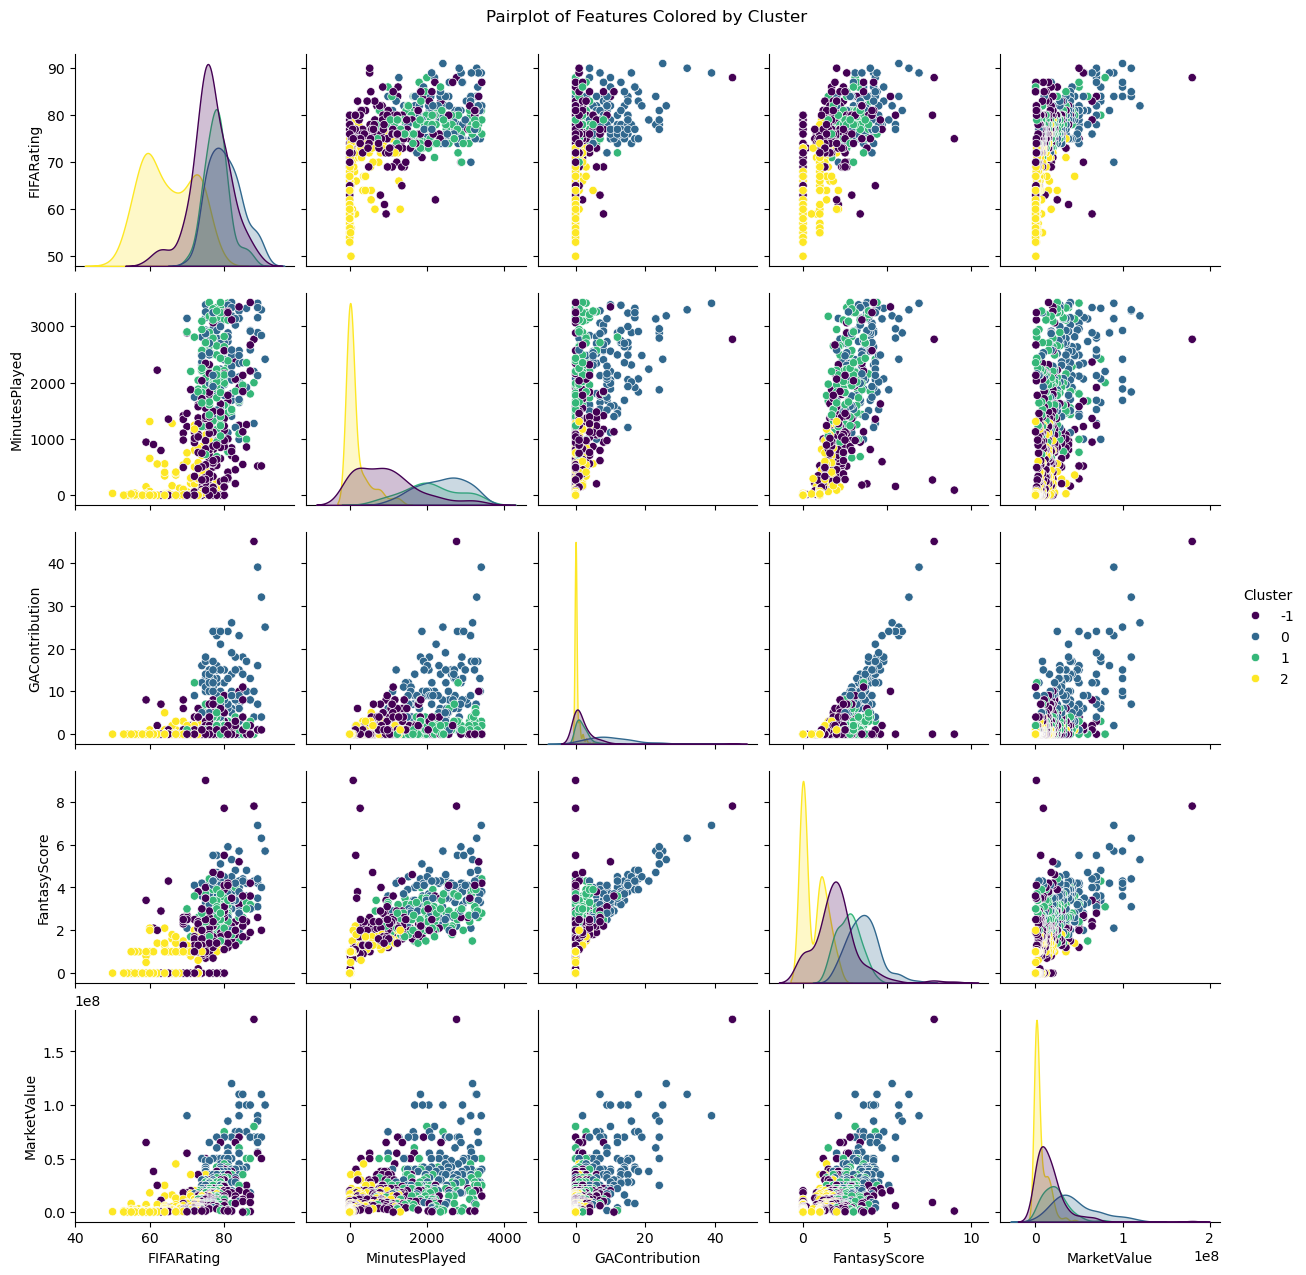

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Columns for clustering
columns = [
    "AgeGroup",
    "Position",
    "FIFARating",
    "MinutesPlayed",
    "GAContribution",
    "FantasyScore",
    "MarketValue",
]

# Encoding qualitative variables
label_encoders = {}
for col in ["AgeGroup", "Position"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing quantitative features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Perform OPTICS clustering
optics = OPTICS(metric="cosine", min_samples=45, xi=.01)
labels = optics.fit_predict(data_scaled)

# Add cluster labels to the dataframe
data["Cluster"] = labels

# Filter out noise points for silhouette and other metrics (-1 is noise in OPTICS)
valid_labels = labels[labels != -1]
valid_data_scaled = data_scaled[labels != -1]

# Calculate validity metrics for valid clusters
if len(set(valid_labels)) > 1:  # Metrics require at least 2 clusters
    silhouette_avg = silhouette_score(valid_data_scaled, valid_labels, metric="cosine")
    davies_bouldin = davies_bouldin_score(valid_data_scaled, valid_labels)
else:
    silhouette_avg = np.nan
    davies_bouldin = np.nan

# Calculate per-cluster silhouette scores
silhouette_vals = silhouette_samples(valid_data_scaled, valid_labels, metric="cosine")

# Create a summary table for clusters
cluster_info = []
numeric_columns = ["FIFARating", "MinutesPlayed", "GAContribution", "FantasyScore", "MarketValue"]

unique_clusters = set(valid_labels)
for cluster_num in unique_clusters:
    cluster_data = data[data["Cluster"] == cluster_num]
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]

    # Metrics for the cluster
    total_members = len(cluster_data)
    variable_iqr = {
        f"IQR {col} (25%-75%)": (np.percentile(cluster_data[col], 25), np.percentile(cluster_data[col], 75))
        for col in numeric_columns
    }
    avg_silhouette = silhouette_vals[valid_labels == cluster_num].mean() if len(cluster_data) > 1 else np.nan
    avg_distance = np.mean(
        cdist(cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cosine")
    )

    cluster_info.append(
        {
            "Cluster Number": cluster_num,
            "Total Members": total_members,
            **variable_iqr,
            "Average Silhouette Score": avg_silhouette,
            "Average Distance from Core": avg_distance,
        }
    )

# Convert cluster summary to DataFrame
cluster_summary_df = pd.DataFrame(cluster_info)

# Compute the Average Within-Cluster Sum of Squares (WCSS)
wcss_list = []
for cluster_num in unique_clusters:
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]
    dist_to_core = cdist(
        cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cosine"
    )
    wcss = np.sum(dist_to_core**2)  # Square of the distances
    wcss_list.append(wcss)

average_wcss = np.mean(wcss_list) if wcss_list else np.nan

# Create a summary table for validity metrics
validity_metrics = {
    "Metric": ["Silhouette Index", "Davies-Bouldin Index", "Average WCSS"],
    "Value": [silhouette_avg, davies_bouldin, average_wcss],
}
validity_metrics_df = pd.DataFrame(validity_metrics)

# Compute pairwise distance matrix between each cluster's core points
cluster_cores = np.array([
    np.mean(valid_data_scaled[valid_labels == cluster_num], axis=0)
    for cluster_num in unique_clusters
])

medoid_dist_matrix = cdist(cluster_cores, cluster_cores, metric="cosine")
medoid_dist_matrix_df = pd.DataFrame(medoid_dist_matrix, columns=[f"Cluster {i}" for i in unique_clusters],
                                      index=[f"Cluster {i}" for i in unique_clusters])

# Output results to CSV files
cluster_summary_df.to_csv("OPcluster_summary_OPTICS.csv", index=False)
validity_metrics_df.to_csv("OPcluster_validity_metrics_OPTICS.csv", index=False)
medoid_dist_matrix_df.to_csv("OPmedoid_distance_matrix_OPTICS.csv")
data.to_csv("OPdata.csv")

# Print the validity metrics
print("Cluster Summary:")
print(cluster_summary_df)
print("\nValidity Metrics:")
print(validity_metrics_df)
print("\nMedoid Distance Matrix:")
print(medoid_dist_matrix_df)

# Plot the reachability plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(optics.reachability_)), optics.reachability_[optics.ordering_], color='skyblue', edgecolor='blue')
plt.xlabel("Sample Index")
plt.ylabel("Reachability Distance")
plt.title("Reachability Plot (Bar Chart)")
plt.savefig("OPreach_clusters_OPTICS.png")
plt.show()

# Pairplot to show pairwise relationships between features
sns.pairplot(data, hue="Cluster", vars=numeric_columns, palette="viridis")
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)

# Save the pairplot as a PNG file
plt.savefig("OPpairplot_clusters_OPTICS.png")
plt.show()


Cluster Summary:
   Cluster Number  Total Members IQR FIFARating (25%-75%)  \
0               0            119             (77.0, 83.5)   
1               1            100             (76.0, 80.0)   
2               2            174             (59.0, 72.0)   

  IQR MinutesPlayed (25%-75%) IQR GAContribution (25%-75%)  \
0            (1920.5, 2884.0)                  (6.0, 14.5)   
1          (1606.25, 2664.75)                   (0.0, 3.0)   
2                (0.0, 166.5)                   (0.0, 0.0)   

  IQR FantasyScore (25%-75%) IQR MarketValue (25%-75%)  \
0                (2.9, 4.15)  (28000000.0, 62500000.0)   
1                 (2.1, 3.2)  (12000000.0, 30000000.0)   
2                 (0.0, 1.1)     (350000.0, 8750000.0)   

   Average Silhouette Score  Average Distance from Core  
0                  0.523429                    0.224914  
1                  0.508878                    0.233052  
2                  0.687780                    0.204290  

Validity Metrics:
     

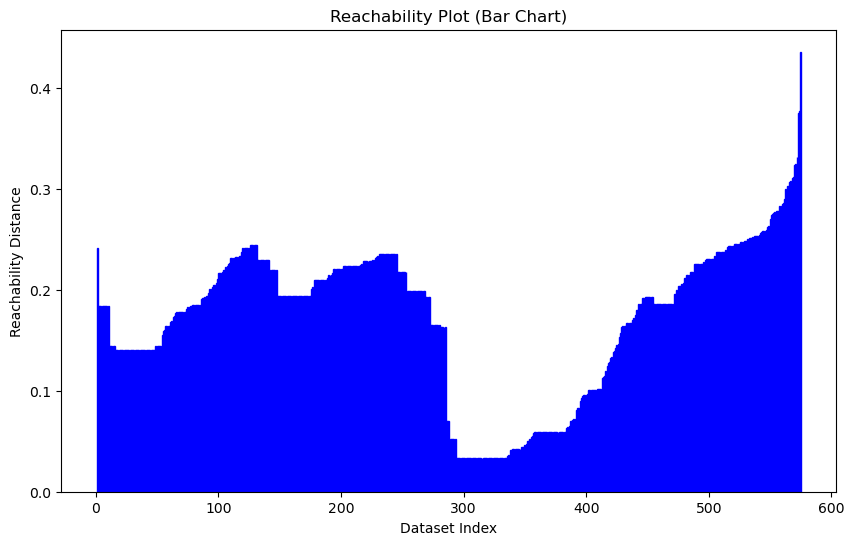

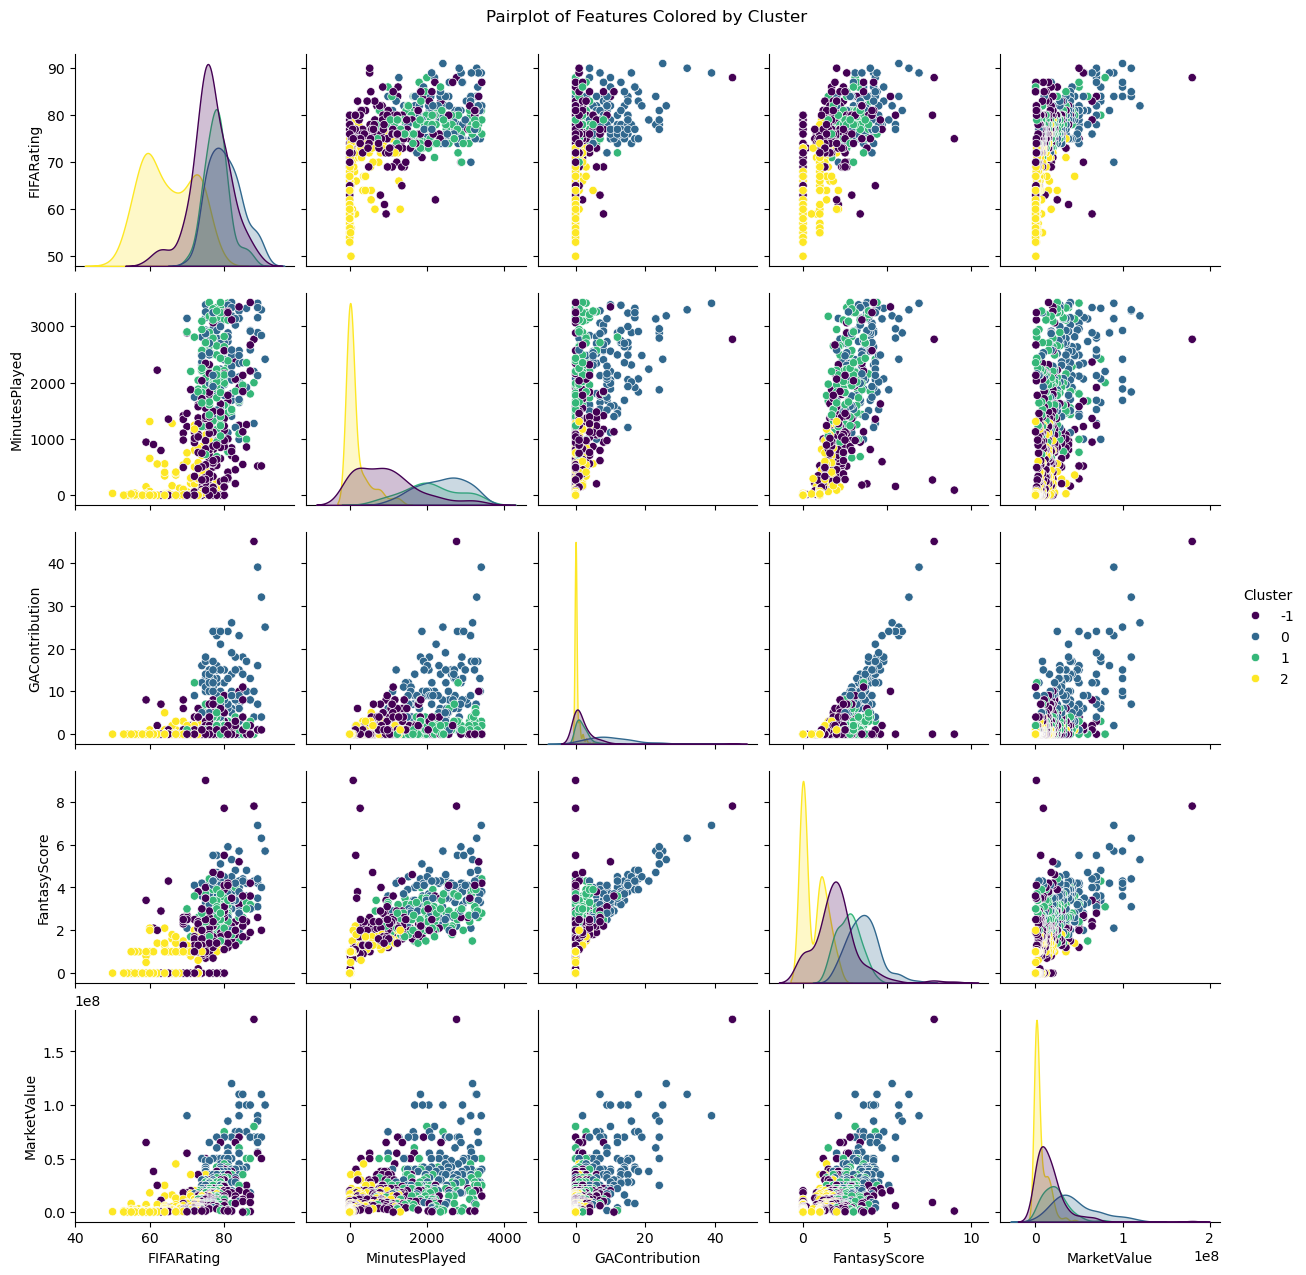

In [71]:
# COSINE with Reachability Plot

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Columns for clustering
columns = [
    "AgeGroup",
    "Position",
    "FIFARating",
    "MinutesPlayed",
    "GAContribution",
    "FantasyScore",
    "MarketValue",
]

# Encoding qualitative variables
label_encoders = {}
for col in ["AgeGroup", "Position"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing quantitative features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Perform OPTICS clustering
optics = OPTICS(metric="cosine", min_samples=45, xi=.01)
labels = optics.fit_predict(data_scaled)

# Add cluster labels to the dataframe
data["Cluster"] = labels

# Filter out noise points for silhouette and other metrics (-1 is noise in OPTICS)
valid_labels = labels[labels != -1]
valid_data_scaled = data_scaled[labels != -1]

# Calculate validity metrics for valid clusters
if len(set(valid_labels)) > 1:  # Metrics require at least 2 clusters
    silhouette_avg = silhouette_score(valid_data_scaled, valid_labels, metric="cosine")
    davies_bouldin = davies_bouldin_score(valid_data_scaled, valid_labels)
else:
    silhouette_avg = np.nan
    davies_bouldin = np.nan

# Calculate per-cluster silhouette scores
silhouette_vals = silhouette_samples(valid_data_scaled, valid_labels, metric="cosine")

# Create a summary table for clusters
cluster_info = []
numeric_columns = ["FIFARating", "MinutesPlayed", "GAContribution", "FantasyScore", "MarketValue"]

unique_clusters = set(valid_labels)
for cluster_num in unique_clusters:
    cluster_data = data[data["Cluster"] == cluster_num]
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]

    # Metrics for the cluster
    total_members = len(cluster_data)
    variable_iqr = {
        f"IQR {col} (25%-75%)": (np.percentile(cluster_data[col], 25), np.percentile(cluster_data[col], 75))
        for col in numeric_columns
    }
    avg_silhouette = silhouette_vals[valid_labels == cluster_num].mean() if len(cluster_data) > 1 else np.nan
    avg_distance = np.mean(
        cdist(cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cosine")
    )

    cluster_info.append(
        {
            "Cluster Number": cluster_num,
            "Total Members": total_members,
            **variable_iqr,
            "Average Silhouette Score": avg_silhouette,
            "Average Distance from Core": avg_distance,
        }
    )

# Convert cluster summary to DataFrame
cluster_summary_df = pd.DataFrame(cluster_info)

# Compute the Average Within-Cluster Sum of Squares (WCSS)
wcss_list = []
for cluster_num in unique_clusters:
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]
    dist_to_core = cdist(
        cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cosine"
    )
    wcss = np.sum(dist_to_core**2)  # Square of the distances
    wcss_list.append(wcss)

average_wcss = np.mean(wcss_list) if wcss_list else np.nan

# Calculate the total number of clustered members (excluding noise)
total_clustered_members = len(valid_labels)

# Create a summary table for validity metrics
validity_metrics = {
    "Metric": ["Silhouette Index", "Davies-Bouldin Index", "Average WCSS", "Total Clustered Members"],
    "Value": [silhouette_avg, davies_bouldin, average_wcss, total_clustered_members],
}
validity_metrics_df = pd.DataFrame(validity_metrics)

# Compute pairwise distance matrix between each cluster's core points
cluster_cores = np.array([
    np.mean(valid_data_scaled[valid_labels == cluster_num], axis=0)
    for cluster_num in unique_clusters
])

medoid_dist_matrix = cdist(cluster_cores, cluster_cores, metric="cosine")
medoid_dist_matrix_df = pd.DataFrame(medoid_dist_matrix, columns=[f"Cluster {i}" for i in unique_clusters],
                                      index=[f"Cluster {i}" for i in unique_clusters])

# Output results to CSV files
cluster_summary_df.to_csv("OPcluster_summary_OPTICS.csv", index=False)
validity_metrics_df.to_csv("OPcluster_validity_metrics_OPTICS.csv", index=False)
medoid_dist_matrix_df.to_csv("OPmedoid_distance_matrix_OPTICS.csv")

# Print the validity metrics
print("Cluster Summary:")
print(cluster_summary_df)
print("\nValidity Metrics:")
print(validity_metrics_df)
print("\nMedoid Distance Matrix:")
print(medoid_dist_matrix_df)

# Plot the reachability plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(optics.reachability_)), optics.reachability_[optics.ordering_], color='skyblue', edgecolor='blue')
plt.xlabel("Dataset Index")
plt.ylabel("Reachability Distance")
plt.title("Reachability Plot (Bar Chart)")
plt.savefig("OPreach_clusters_OPTICS.png")
plt.show()

# Pairplot to show pairwise relationships between features
sns.pairplot(data, hue="Cluster", vars=numeric_columns, palette="viridis")
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)

# Save the pairplot as a PNG file
plt.savefig("OPpairplot_clusters_OPTICS.png")
plt.show()


In [79]:
data_OP = pd.read_csv('/Users/niloy74/UoB/Data Analytics and Predictive Modelling/OPdata.csv')
data_OP

,Unnamed: 0,FullName,ClubName,AgeGroup,Position,FIFARating,MinutesPlayed,GAContribution,FantasyScore,MarketValue,TransferStatus,Cluster
0,1,Bukayo Saka,Arsenal,0,3,82,3183,26,5.3,120000000,Retained,0
1,2,Declan Rice,West Ham United,1,3,84,3272,7,3.1,110000000,Transferred,0
2,3,Mohamed Salah,Liverpool,3,1,90,3290,32,6.3,110000000,Retained,0
3,4,Phil Foden,Manchester City,1,3,85,1832,18,4.4,110000000,Retained,0
4,5,Jadon Sancho,Manchester United,1,3,84,1683,9,4.0,100000000,Transferred,0
...,...,...,...,...,...,...,...,...,...,...,...,...
388,570,Killian Phillips,Crystal Palace,0,3,58,0,0,0.0,150000,Transferred,2
389,571,Alex Gilbert,Brentford,0,1,59,0,0,0.0,100000,Retained,2
390,572,Lewis Brunt,Leicester City,0,3,55,22,0,1.0,100000,Retained,2
391,573,Tristan Crama,Brentford,0,0,58,0,0,0.0,100000,Retained,2


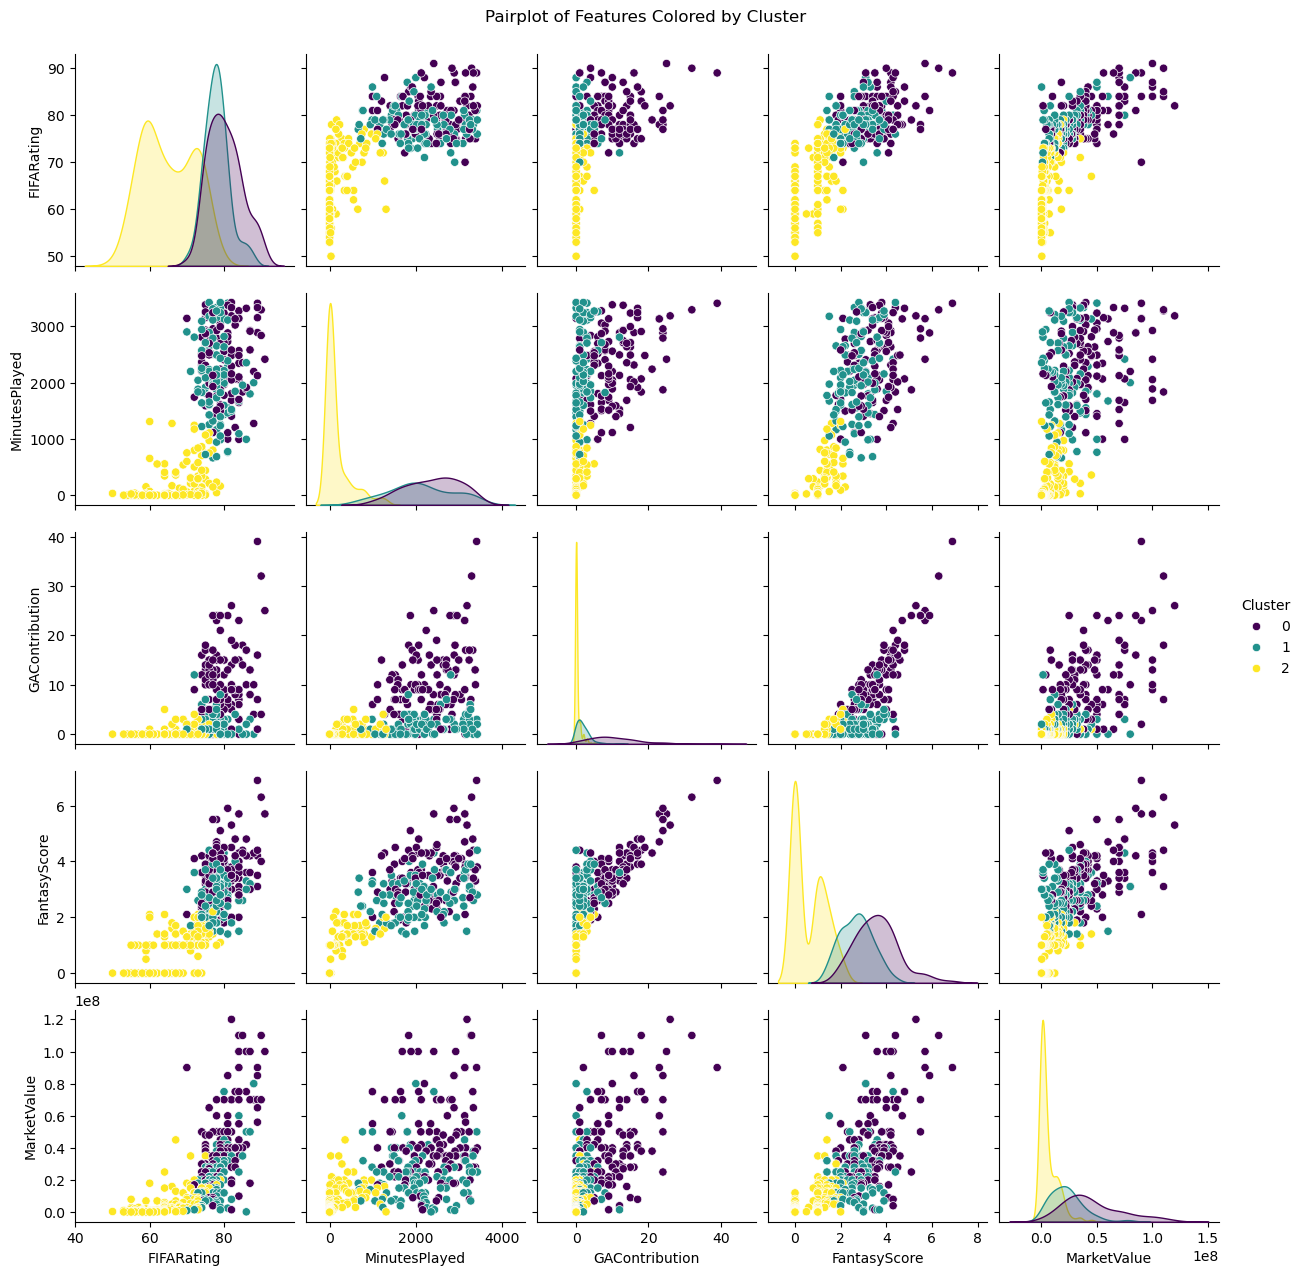

In [83]:
# Pairplot to show pairwise relationships between features
sns.pairplot(data_OP, hue="Cluster", vars=numeric_columns, palette="viridis")
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)
plt.savefig("FInal_pairplot_clusters_OPTICS.png")
plt.show()

Cluster Summary:
   Cluster Number  Total Members IQR FIFARating (25%-75%)  \
0               0             75             (74.0, 77.0)   
1               1            124            (58.0, 64.25)   

  IQR MinutesPlayed (25%-75%) IQR GAContribution (25%-75%)  \
0             (715.5, 1758.5)                   (0.0, 2.0)   
1                  (0.0, 1.0)                   (0.0, 0.0)   

  IQR FantasyScore (25%-75%) IQR MarketValue (25%-75%)  \
0                 (1.5, 2.3)   (8000000.0, 18000000.0)   
1                (0.0, 0.05)     (250000.0, 2000000.0)   

   Average Silhouette Score  Average Distance from Core  
0                  0.564491                    2.392813  
1                  0.608316                    2.328874  

Validity Metrics:
                    Metric       Value
0         Silhouette Index    0.591799
1     Davies-Bouldin Index    0.835309
2             Average WCSS  600.888026
3  Total Clustered Members  199.000000

Medoid Distance Matrix:
           Cluster 0  Cl

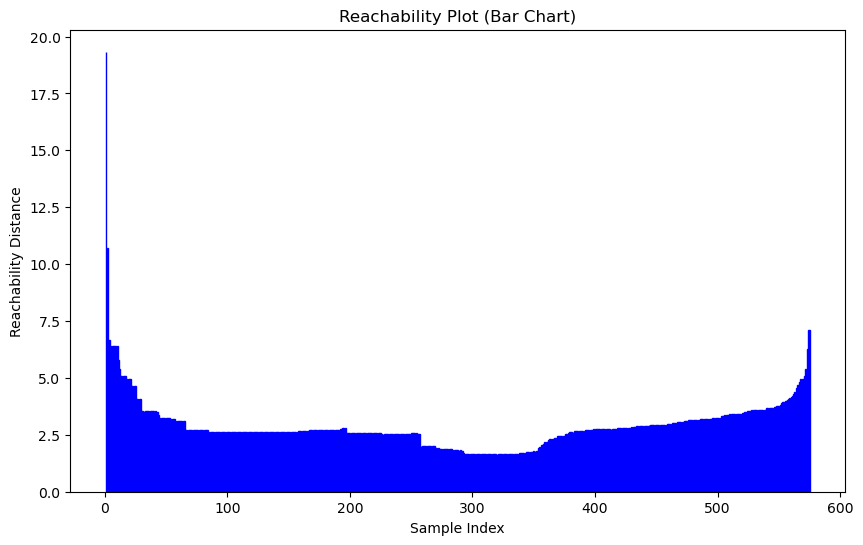

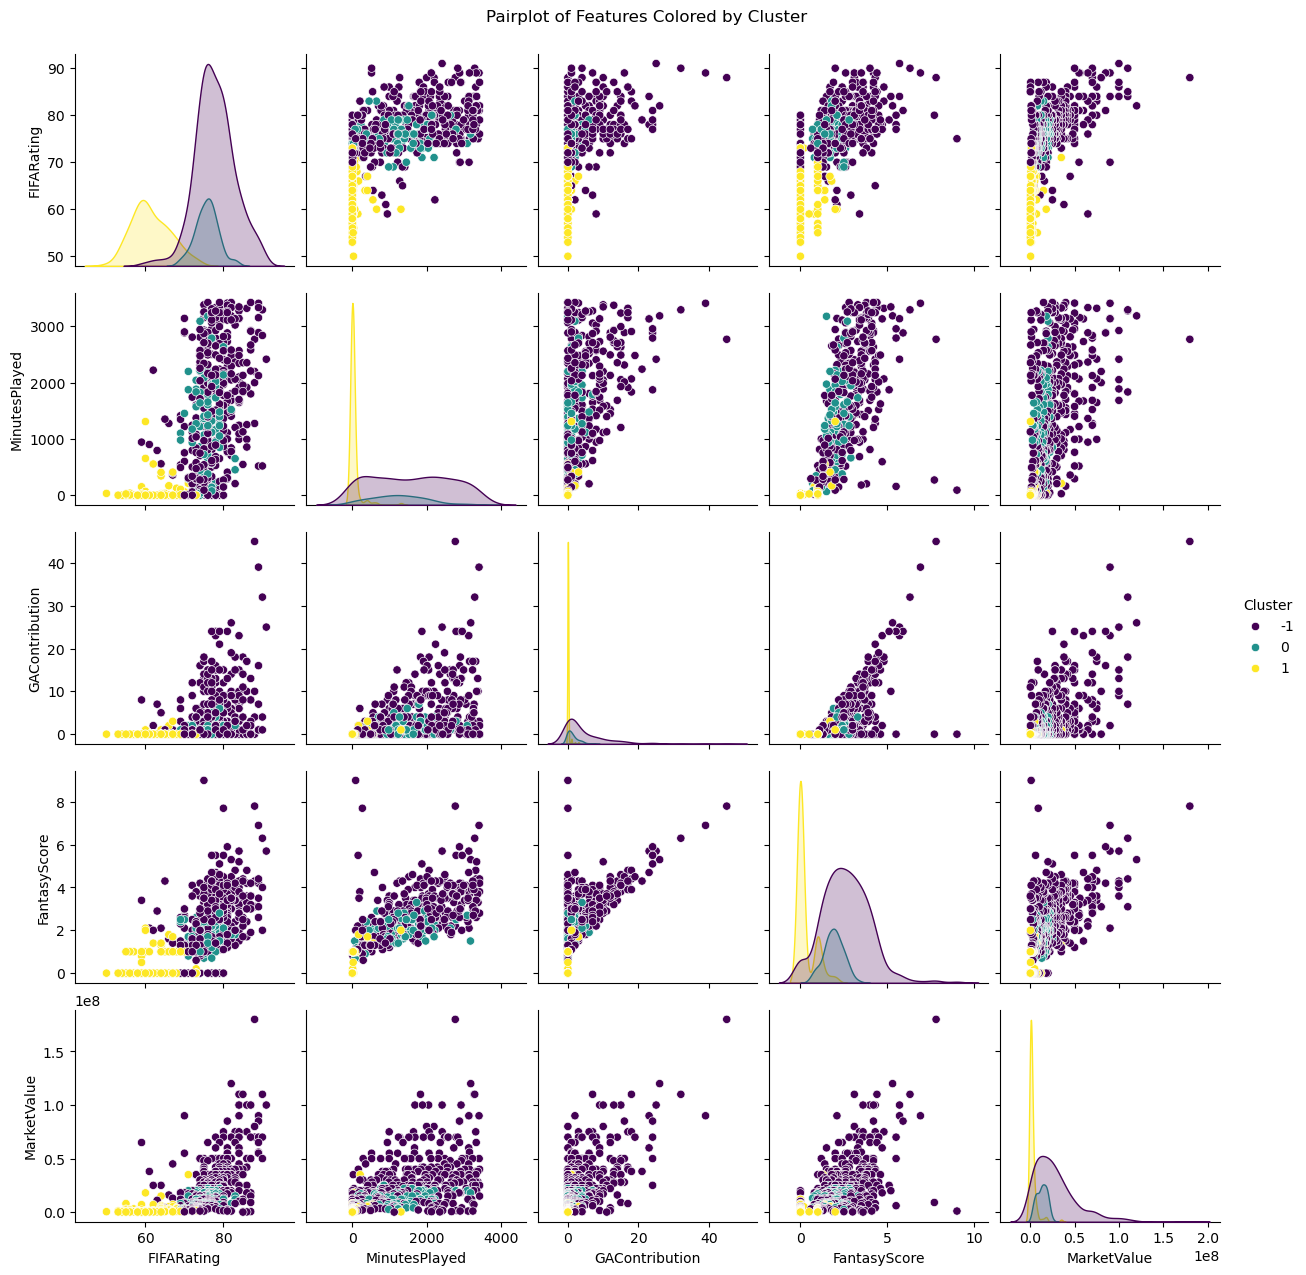

In [33]:
# Manhattan with Reachability Plot

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Columns for clustering
columns = [
    "AgeGroup",
    "Position",
    "FIFARating",
    "MinutesPlayed",
    "GAContribution",
    "FantasyScore",
    "MarketValue",
]

# Encoding qualitative variables
label_encoders = {}
for col in ["AgeGroup", "Position"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing quantitative features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Perform OPTICS clustering
optics = OPTICS(metric="manhattan", min_samples=60, xi=.01)
labels = optics.fit_predict(data_scaled)

# Add cluster labels to the dataframe
data["Cluster"] = labels

# Filter out noise points for silhouette and other metrics (-1 is noise in OPTICS)
valid_labels = labels[labels != -1]
valid_data_scaled = data_scaled[labels != -1]

# Calculate validity metrics for valid clusters
if len(set(valid_labels)) > 1:  # Metrics require at least 2 clusters
    silhouette_avg = silhouette_score(valid_data_scaled, valid_labels, metric="manhattan")
    davies_bouldin = davies_bouldin_score(valid_data_scaled, valid_labels)
else:
    silhouette_avg = np.nan
    davies_bouldin = np.nan

# Calculate per-cluster silhouette scores
silhouette_vals = silhouette_samples(valid_data_scaled, valid_labels, metric="manhattan")

# Create a summary table for clusters
cluster_info = []
numeric_columns = ["FIFARating", "MinutesPlayed", "GAContribution", "FantasyScore", "MarketValue"]

unique_clusters = set(valid_labels)
for cluster_num in unique_clusters:
    cluster_data = data[data["Cluster"] == cluster_num]
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]

    # Metrics for the cluster
    total_members = len(cluster_data)
    variable_iqr = {
        f"IQR {col} (25%-75%)": (np.percentile(cluster_data[col], 25), np.percentile(cluster_data[col], 75))
        for col in numeric_columns
    }
    avg_silhouette = silhouette_vals[valid_labels == cluster_num].mean() if len(cluster_data) > 1 else np.nan
    avg_distance = np.mean(
        cdist(cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cityblock")
    )

    cluster_info.append(
        {
            "Cluster Number": cluster_num,
            "Total Members": total_members,
            **variable_iqr,
            "Average Silhouette Score": avg_silhouette,
            "Average Distance from Core": avg_distance,
        }
    )

# Convert cluster summary to DataFrame
cluster_summary_df = pd.DataFrame(cluster_info)

# Compute the Average Within-Cluster Sum of Squares (WCSS)
wcss_list = []
for cluster_num in unique_clusters:
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]
    dist_to_core = cdist(
        cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="cityblock"
    )
    wcss = np.sum(dist_to_core**2)  # Square of the distances
    wcss_list.append(wcss)

average_wcss = np.mean(wcss_list) if wcss_list else np.nan

# Calculate the total number of clustered members (excluding noise)
total_clustered_members = len(valid_labels)

# Create a summary table for validity metrics
validity_metrics = {
    "Metric": ["Silhouette Index", "Davies-Bouldin Index", "Average WCSS", "Total Clustered Members"],
    "Value": [silhouette_avg, davies_bouldin, average_wcss, total_clustered_members],
}
validity_metrics_df = pd.DataFrame(validity_metrics)

# Compute pairwise distance matrix between each cluster's core points
cluster_cores = np.array([
    np.mean(valid_data_scaled[valid_labels == cluster_num], axis=0)
    for cluster_num in unique_clusters
])

medoid_dist_matrix = cdist(cluster_cores, cluster_cores, metric="cityblock")
medoid_dist_matrix_df = pd.DataFrame(medoid_dist_matrix, columns=[f"Cluster {i}" for i in unique_clusters],
                                      index=[f"Cluster {i}" for i in unique_clusters])

# Output results to CSV files
cluster_summary_df.to_csv("OPcluster_summary_OPTICS.csv", index=False)
validity_metrics_df.to_csv("OPcluster_validity_metrics_OPTICS.csv", index=False)
medoid_dist_matrix_df.to_csv("OPmedoid_distance_matrix_OPTICS.csv")

# Print the validity metrics
print("Cluster Summary:")
print(cluster_summary_df)
print("\nValidity Metrics:")
print(validity_metrics_df)
print("\nMedoid Distance Matrix:")
print(medoid_dist_matrix_df)

# Plot the reachability plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(optics.reachability_)), optics.reachability_[optics.ordering_], color='skyblue', edgecolor='blue')
plt.xlabel("Sample Index")
plt.ylabel("Reachability Distance")
plt.title("Reachability Plot (Bar Chart)")
plt.show()

# Pairplot to show pairwise relationships between features
sns.pairplot(data, hue="Cluster", vars=numeric_columns, palette="viridis")
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)

# Save the pairplot as a PNG file
plt.savefig("OPpairplot_clusters_OPTICS.png")
plt.show()


In [3]:
# Euclidean with Reachability Plot

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Columns for clustering
columns = [
    "AgeGroup",
    "Position",
    "FIFARating",
    "MinutesPlayed",
    "GAContribution",
    "FantasyScore",
    "MarketValue",
]

# Encoding qualitative variables
label_encoders = {}
for col in ["AgeGroup", "Position"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing quantitative features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Perform OPTICS clustering
optics = OPTICS(metric="euclidean", min_samples=55, xi=.02)
labels = optics.fit_predict(data_scaled)

# Add cluster labels to the dataframe
data["Cluster"] = labels

# Filter out noise points for silhouette and other metrics (-1 is noise in OPTICS)
valid_labels = labels[labels != -1]
valid_data_scaled = data_scaled[labels != -1]

# Calculate validity metrics for valid clusters
if len(set(valid_labels)) > 1:  # Metrics require at least 2 clusters
    silhouette_avg = silhouette_score(valid_data_scaled, valid_labels, metric="euclidean")
    davies_bouldin = davies_bouldin_score(valid_data_scaled, valid_labels)
else:
    silhouette_avg = np.nan
    davies_bouldin = np.nan

# Calculate per-cluster silhouette scores
silhouette_vals = silhouette_samples(valid_data_scaled, valid_labels, metric="euclidean")

# Create a summary table for clusters
cluster_info = []
numeric_columns = ["FIFARating", "MinutesPlayed", "GAContribution", "FantasyScore", "MarketValue"]

unique_clusters = set(valid_labels)
for cluster_num in unique_clusters:
    cluster_data = data[data["Cluster"] == cluster_num]
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]

    # Metrics for the cluster
    total_members = len(cluster_data)
    variable_iqr = {
        f"IQR {col} (25%-75%)": (np.percentile(cluster_data[col], 25), np.percentile(cluster_data[col], 75))
        for col in numeric_columns
    }
    avg_silhouette = silhouette_vals[valid_labels == cluster_num].mean() if len(cluster_data) > 1 else np.nan
    avg_distance = np.mean(
        cdist(cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="euclidean")
    )

    cluster_info.append(
        {
            "Cluster Number": cluster_num,
            "Total Members": total_members,
            **variable_iqr,
            "Average Silhouette Score": avg_silhouette,
            "Average Distance from Core": avg_distance,
        }
    )

# Convert cluster summary to DataFrame
cluster_summary_df = pd.DataFrame(cluster_info)

# Compute the Average Within-Cluster Sum of Squares (WCSS)
wcss_list = []
for cluster_num in unique_clusters:
    cluster_data_scaled = valid_data_scaled[valid_labels == cluster_num]
    dist_to_core = cdist(
        cluster_data_scaled, np.array([np.mean(cluster_data_scaled, axis=0)]), metric="euclidean"
    )
    wcss = np.sum(dist_to_core**2)  # Square of the distances
    wcss_list.append(wcss)

average_wcss = np.mean(wcss_list) if wcss_list else np.nan

# Calculate the total number of clustered members (excluding noise)
total_clustered_members = len(valid_labels)

# Create a summary table for validity metrics
validity_metrics = {
    "Metric": ["Silhouette Index", "Davies-Bouldin Index", "Average WCSS", "Total Clustered Members"],
    "Value": [silhouette_avg, davies_bouldin, average_wcss, total_clustered_members],
}
validity_metrics_df = pd.DataFrame(validity_metrics)

# Compute pairwise distance matrix between each cluster's core points
cluster_cores = np.array([
    np.mean(valid_data_scaled[valid_labels == cluster_num], axis=0)
    for cluster_num in unique_clusters
])

medoid_dist_matrix = cdist(cluster_cores, cluster_cores, metric="euclidean")
medoid_dist_matrix_df = pd.DataFrame(medoid_dist_matrix, columns=[f"Cluster {i}" for i in unique_clusters],
                                      index=[f"Cluster {i}" for i in unique_clusters])

# Output results to CSV files
cluster_summary_df.to_csv("EUcluster_summary_OPTICS.csv", index=False)
validity_metrics_df.to_csv("EUcluster_validity_metrics_OPTICS.csv", index=False)
medoid_dist_matrix_df.to_csv("EUmedoid_distance_matrix_OPTICS.csv")

# Print the validity metrics
print("Cluster Summary:")
print(cluster_summary_df)
print("\nValidity Metrics:")
print(validity_metrics_df)
print("\nMedoid Distance Matrix:")
print(medoid_dist_matrix_df)

# Plot the reachability plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(optics.reachability_)), optics.reachability_[optics.ordering_], color='skyblue', edgecolor='blue')
plt.xlabel("Sample Index")
plt.ylabel("Reachability Distance")
plt.title("EU Reachability Plot (Bar Chart)")
plt.show()

# Pairplot to show pairwise relationships between features
sns.pairplot(data, hue="Cluster", vars=numeric_columns, palette="viridis")
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)

# Save the pairplot as a PNG file
plt.savefig("EUpairplot_clusters_OPTICS.png")
plt.show()


NameError: name 'data' is not defined